# Set up

In [ ]:
!pip install optuna optuna-integration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Dropout, LSTM, TimeDistributed
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers

import optuna
from optuna.visualization import plot_optimization_history
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from datetime import datetime
import os
import math
import pickle
import joblib

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tokens = ["BIDV_BID", "FPT", "VCG"]

prj_path = "/content/drive/My Drive/BDA_report/"
data_path = os.path.join(prj_path, "data/")

targets = ["Price"]
data_set = {1: "train", 2: "test"}
model_name = "seq2seq"

T = 60 #lookback
TF = 1 #predict
NFeature = 1 #feautures

n_try_opt=100

%cd $prj_path

/content/drive/My Drive/BDA_report


In [ ]:
data_source = '/content/drive/My Drive/BDA_report/'
processed_output_dir = os.path.join(data_source,  "processing/")

%cd $data_source

/content/drive/My Drive/BDA_report


In [ ]:
#@title DEFINITIONS

def MinMaxNormalization(df, data_set_index):
  """
  Params:
      * df -- DataFrame:        Dataframe need to be scaled
      * data_set_index -- int:  A number to recognize that dataset is train/test/validation
  Returns:
      * scaler:     used for future inverse-transform
      * df_scaled:  df after normalization
  """
  scaler = MinMaxScaler()
  norm_set = data_set[data_set_index]

  processes_folder = f"{processed_output_dir}/{tokens[token_id]}"
  os.makedirs(processes_folder, exist_ok=True)

  if norm_set == "train":
    scaler.fit(df)
    series = scaler.transform(df)
    df_scaled = pd.DataFrame(data=series, columns = df.columns)
    out_scaler_file = os.path.join(processed_output_dir, f"{tokens[token_id]}/{targets[0]}_{norm_set}_scalerMinMaxNorm.save")
    joblib.dump(scaler, out_scaler_file)
    print(os.path.exists(out_scaler_file))

  else:
    scaler = joblib.load(os.path.join(processed_output_dir, f"{tokens[token_id]}/{targets[0]}_train_scalerMinMaxNorm.save"))
    series = scaler.transform(df)
    df_scaled = pd.DataFrame(data = series, columns = df.columns)

  out_file = os.path.join(processed_output_dir, f"{tokens[token_id]}/{targets[0]}_{norm_set}_scaler.xlsx")
  df_scaled.to_excel(out_file, float_format='%.5f')
  print(out_file)
  return df_scaled,scaler

#---------------------
def getRawData(token_id):
  raw_data_file=f"{tokens[token_id]}.csv"
  df = pd.read_csv(data_path + raw_data_file,  index_col="Date")
  colsFeature = ["Price"]
  df_target = df[colsFeature]
  return df_target

#---------------------
def getData(data_dir = "processing", subset = "train", token_id  = 0):
    df = pd.read_excel(f"{data_dir}/{tokens[token_id]}/{targets[0]}_{subset}_scaler.xlsx")
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

#---------------------
def evaluate(df, title, actual, predict):
  rmse = np.sqrt(mean_squared_error(actual, predict))
  mape = mean_absolute_percentage_error(actual, predict)

  df[f"rmse_{title}"].append(rmse)
  df[f"mape_{title}"].append(mape)
  return df

#---------------------
#Define supervised data
def getSupervisedData(df, T, TF):
  NDay = len(df)
  D = 1
  series = df.to_numpy()
  X = []
  Y = []
  for t in range(len(series) - T - TF + 1):
    x = series[t:t+T,-1]
    X.append(x)

    y = series[t+T:t+T+TF,-1]
    Y.append(y)
  Xtrain = np.array(X).astype(float)
  Ytrain = np.array(Y).astype(float).reshape(len(Y),)
  return Xtrain,Ytrain

#---------------------
#Define Model
def Seq2SeqModel(T = 60, NFeature = 1):

  encoder_inputs = tf.keras.layers.Input(shape=(T, NFeature))

  encoder_cell = tf.keras.layers.LSTM(128, return_state=True, name='encoder_layer')

  encoder_outputs_and_states = encoder_cell(encoder_inputs)

  encoder_states = encoder_outputs_and_states[1:] # only keep the states

  decoder_inputs = keras.layers.Input(shape=(None, 1), name='decoder_input') #### <=== must be 1

  decoder_cell = tf.keras.layers.LSTM(128, return_state=True, return_sequences=True, name='decoder_layer')

  decoder_outputs_and_states = decoder_cell(decoder_inputs, initial_state=encoder_states)

  decoder_outputs = decoder_outputs_and_states[0] # only keep the output sequence
  decoder_dense = keras.layers.Dense(1)

  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
  model.compile(optimizer='adam',
                loss='mse')

  return model

# BIDV





---


**BIDV 7:3**

In [ ]:
# working on
token_id = 0 #BIDV

df = getRawData(token_id)
print(df.head(3))

            Price
Date             
3/1/2017  11235.8
4/1/2017  11458.3
5/1/2017  11421.2


In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.7)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/BIDV_BID/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/BIDV_BID/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
34/34 [==============================] - 11s 175ms/step - loss: 0.0193
Epoch 2/100
34/34 [==============================] - 5s 138ms/step - loss: 0.0018
Epoch 3/100
34/34 [==============================] - 5s 139ms/step - loss: 0.0015
Epoch 4/100
34/34 [==============================] - 6s 164ms/step - loss: 0.0014
Epoch 5/100
34/34 [==============================] - 5s 140ms/step - loss: 0.0014
Epoch 6/100
34/34 [==============================] - 5s 145ms/step - loss: 0.0012
Epoch 7/100
34/34 [==============================] - 6s 162ms/step - loss: 0.0012
Epoch 8/100
34/34 [==============================] - 2s 71ms/step - loss: 0.0011
Epoch 9/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0011
Epoch 10/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0012
Epoch 11/100
34/34 [==============================] - 3s 79ms/step - loss: 0.0010
Epoch 12/100
34/34 [==============================] - 4s 122ms/step - loss: 9.6950e-04
Epoch 13/100

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


14/14 [==============================] - 1s 53ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,682.293261,0.017967,1011.007411,0.019546


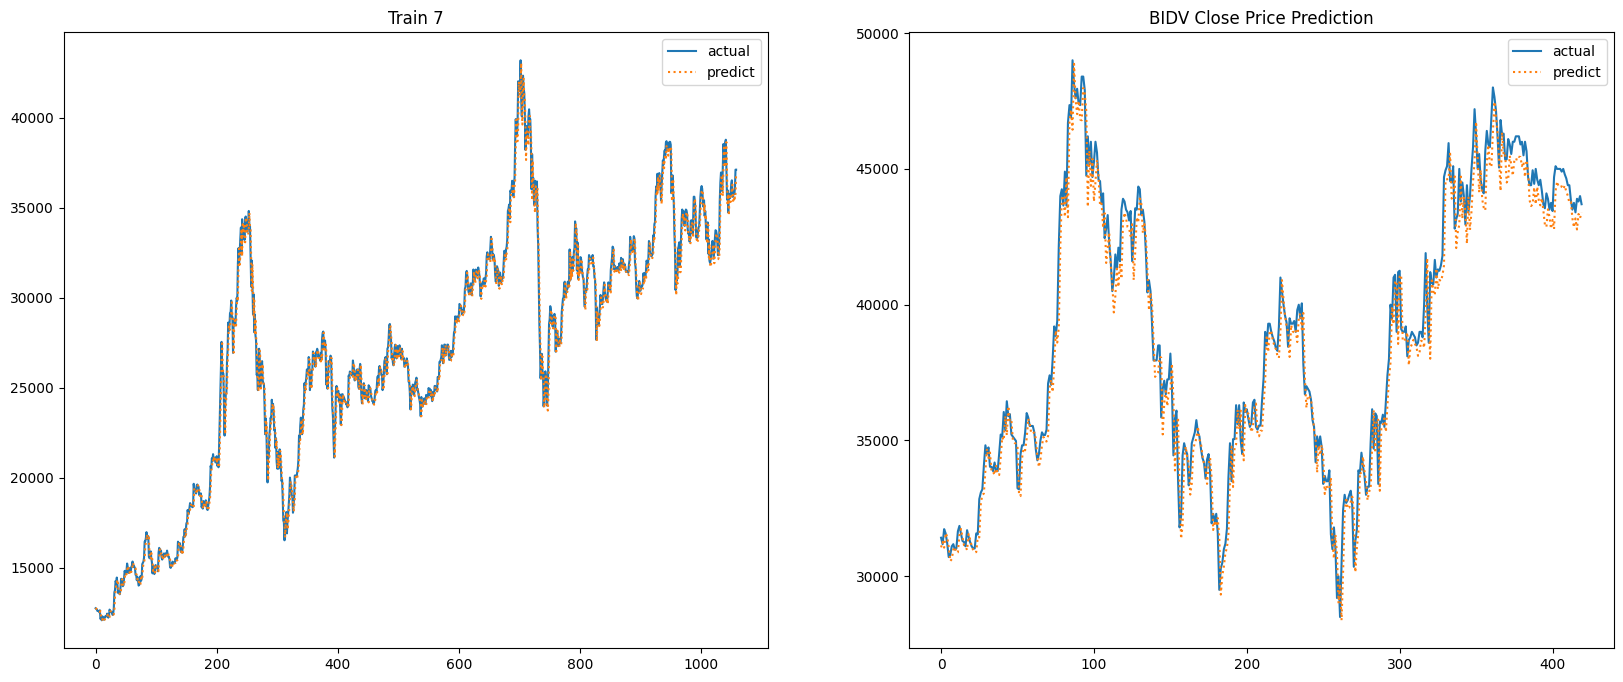

   rmse_train  mape_train    rmse_test  mape_test
0  682.293261    0.017967  1011.007411   0.019546


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 7")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 3")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_BIDV_73.png")
plt.title('BIDV Close Price Prediction')
plt.show()

print(metrics_df)



---


**BIDV 8:2**

In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.8)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/BIDV_BID/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/BIDV_BID/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
39/39 [==============================] - 16s 151ms/step - loss: 0.0304
Epoch 2/100
39/39 [==============================] - 5s 140ms/step - loss: 0.0017
Epoch 3/100
39/39 [==============================] - 4s 106ms/step - loss: 0.0013
Epoch 4/100
39/39 [==============================] - 3s 71ms/step - loss: 0.0012
Epoch 5/100
39/39 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 6/100
39/39 [==============================] - 3s 71ms/step - loss: 0.0010
Epoch 7/100
39/39 [==============================] - 4s 111ms/step - loss: 9.8755e-04
Epoch 8/100
39/39 [==============================] - 3s 83ms/step - loss: 9.4132e-04
Epoch 9/100
39/39 [==============================] - 3s 71ms/step - loss: 8.7756e-04
Epoch 10/100
39/39 [==============================] - 3s 72ms/step - loss: 8.8691e-04
Epoch 11/100
39/39 [==============================] - 3s 77ms/step - loss: 8.7622e-04
Epoch 12/100
39/39 [==============================] - 5s 117ms/step - loss: 7.7317

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_2[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


9/9 [==============================] - 0s 25ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,689.88704,0.017285,919.335572,0.017565


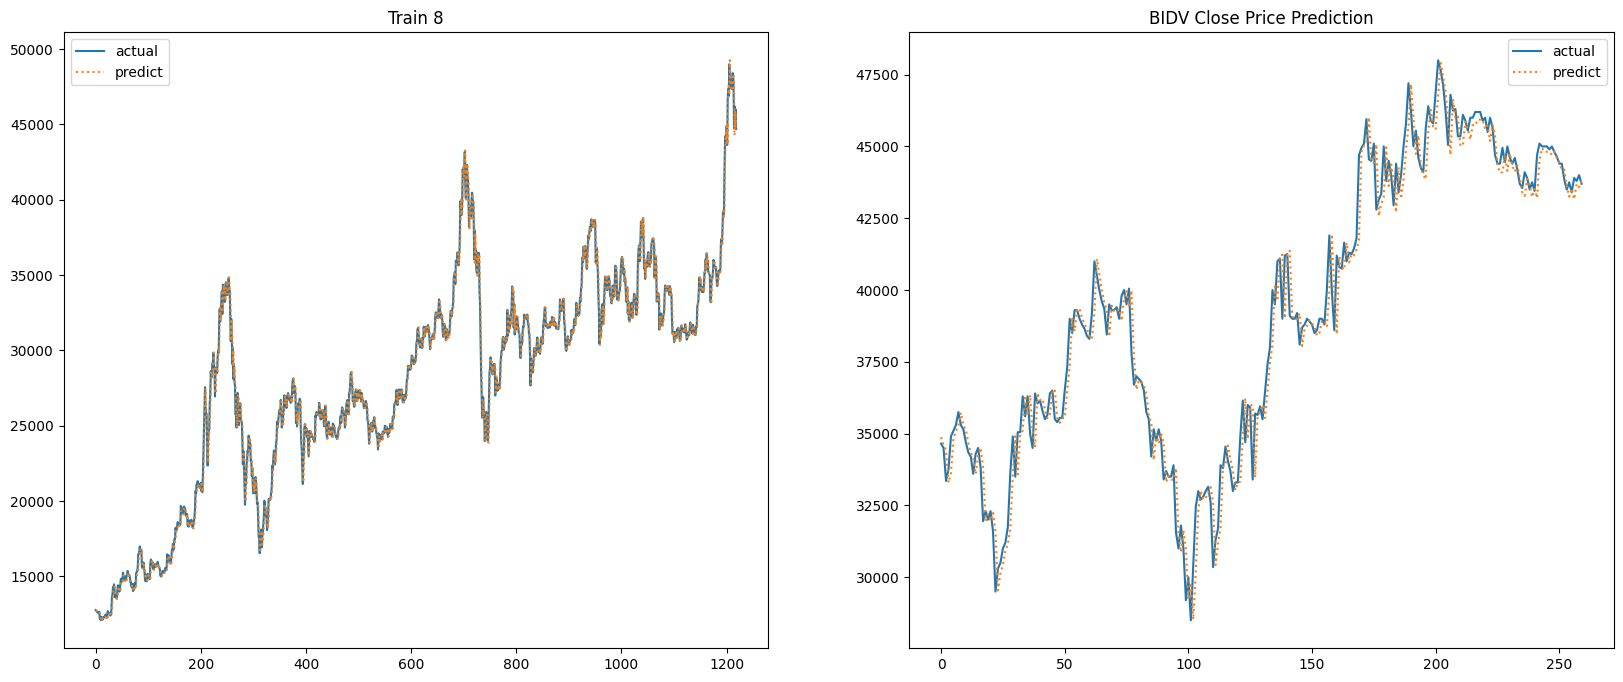

   rmse_train  mape_train   rmse_test  mape_test
0   689.88704    0.017285  919.335572   0.017565


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 8")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 2")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_BIDV_82.png")
plt.title('BIDV Close Price Prediction')
plt.show()

print(metrics_df)



---


**BIDV 7.5:2.5**



In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.75)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/BIDV_BID/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/BIDV_BID/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
36/36 [==============================] - 8s 85ms/step - loss: 0.0360
Epoch 2/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0025
Epoch 3/100
36/36 [==============================] - 3s 71ms/step - loss: 0.0017
Epoch 4/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0015
Epoch 5/100
36/36 [==============================] - 4s 123ms/step - loss: 0.0014
Epoch 6/100
36/36 [==============================] - 3s 77ms/step - loss: 0.0014
Epoch 7/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0013
Epoch 8/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0012
Epoch 9/100
36/36 [==============================] - 3s 75ms/step - loss: 0.0012
Epoch 10/100
36/36 [==============================] - 5s 127ms/step - loss: 0.0011
Epoch 11/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0010
Epoch 12/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0010
Epoch 13/100
36/36 [===

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_3[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


11/11 [==============================] - 1s 47ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,669.327518,0.017353,1078.613024,0.021104


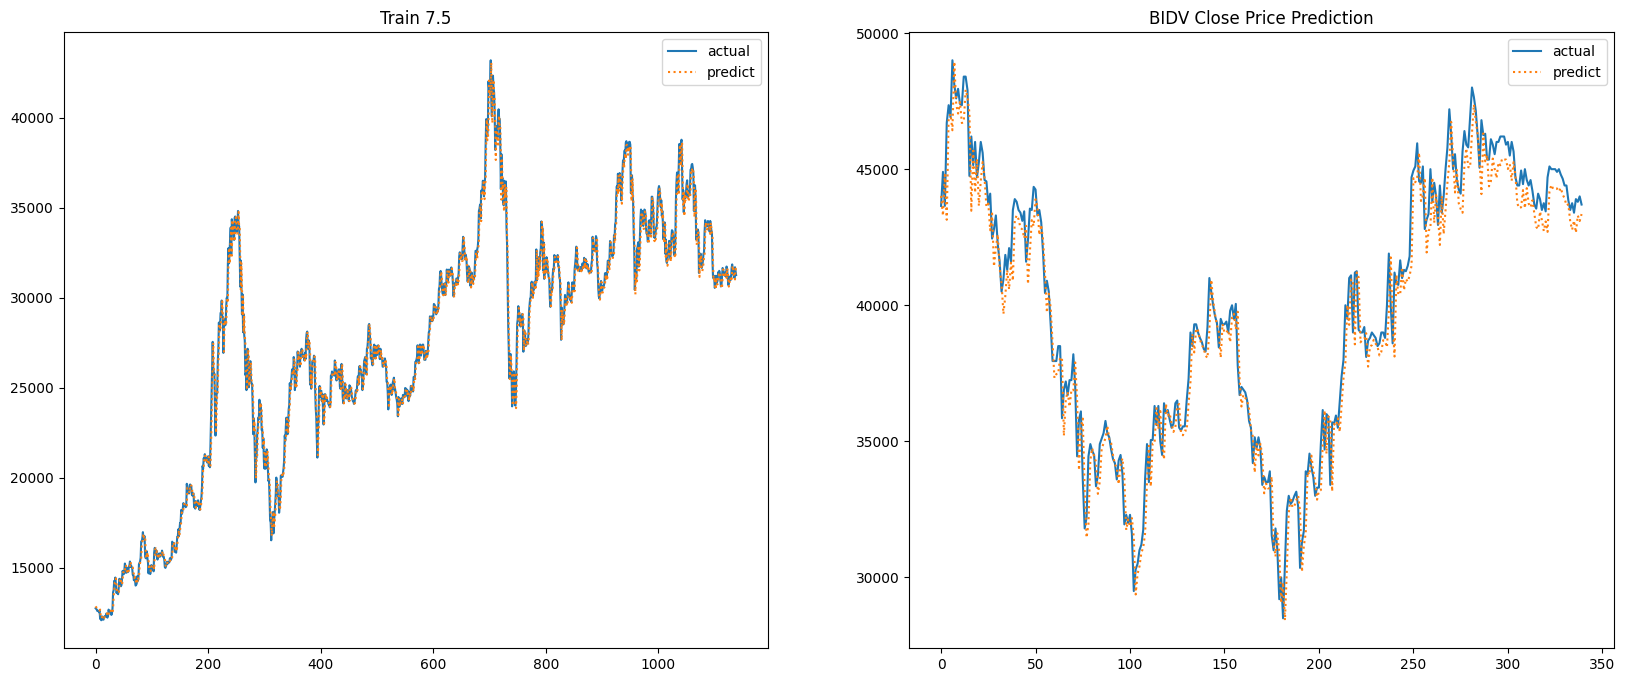

   rmse_train  mape_train    rmse_test  mape_test
0  669.327518    0.017353  1078.613024   0.021104


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 7.5")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 2.5")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_BIDV_7.5_2.5.png")
plt.title('BIDV Close Price Prediction')
plt.show()

print(metrics_df)

# FPT





---


**FPT 7:3**

In [ ]:
# working on
token_id = 1 #FPT

df = getRawData(token_id)
print(df.head(3))

            Price
Date             
1/3/2017  16158.2
1/4/2017  16302.3
1/5/2017  16248.3


In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.7)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/FPT/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/FPT/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
36/36 [==============================] - 7s 75ms/step - loss: 0.0278
Epoch 2/100
36/36 [==============================] - 3s 92ms/step - loss: 0.0021
Epoch 3/100
36/36 [==============================] - 4s 110ms/step - loss: 0.0015
Epoch 4/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0015
Epoch 5/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0014
Epoch 6/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0013
Epoch 7/100
36/36 [==============================] - 4s 102ms/step - loss: 0.0013
Epoch 8/100
36/36 [==============================] - 4s 100ms/step - loss: 0.0012
Epoch 9/100
36/36 [==============================] - 3s 74ms/step - loss: 0.0012
Epoch 10/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 11/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0011
Epoch 12/100
36/36 [==============================] - 4s 113ms/step - loss: 0.0010
Epoch 13/100
36/36 [=

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_4[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


11/11 [==============================] - 0s 38ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,1243.76567,0.019393,1874.426015,0.020689


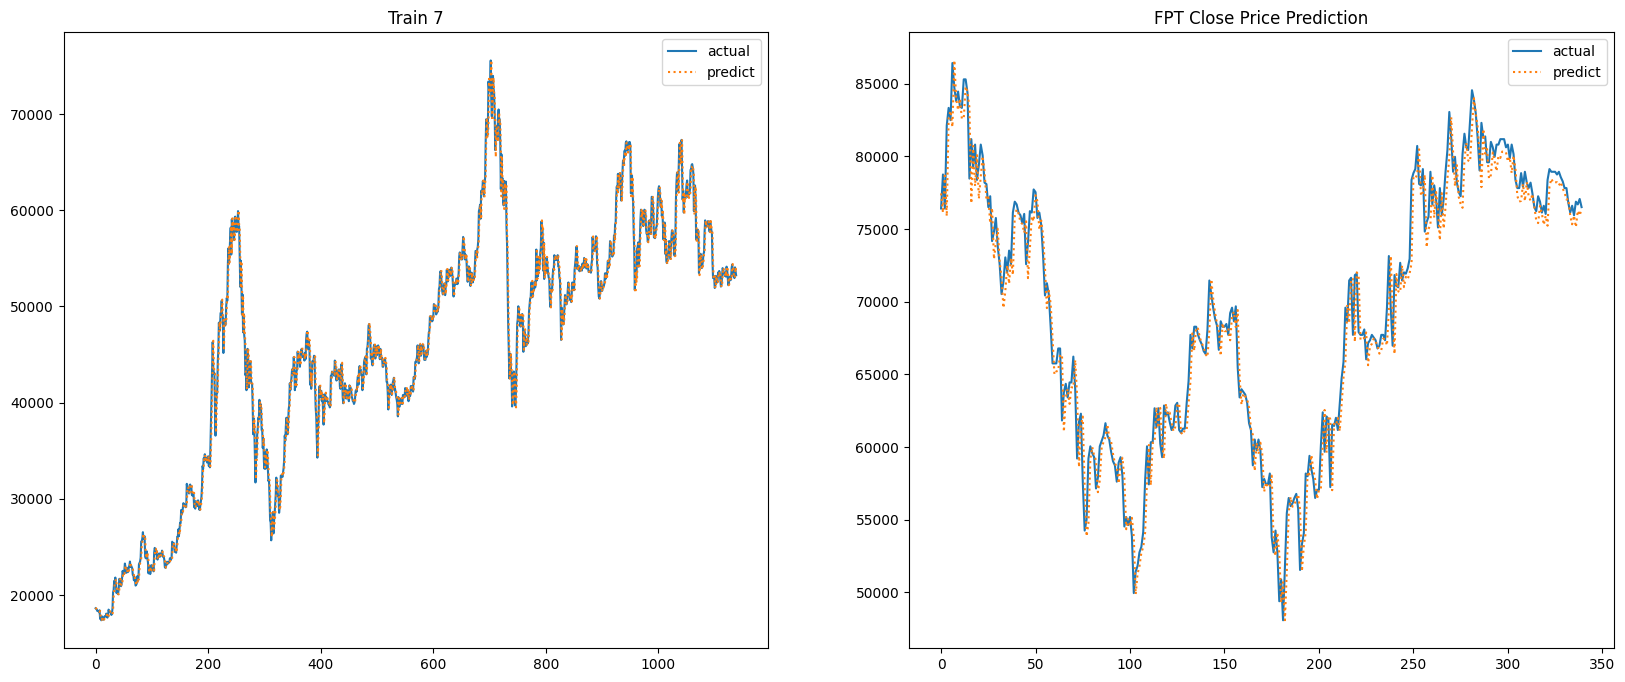

   rmse_train  mape_train    rmse_test  mape_test
0  1243.76567    0.019393  1874.426015   0.020689


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 7")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 3")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_FPT_73.png")
plt.title('FPT Close Price Prediction')
plt.show()

print(metrics_df)



---


**FPT 8:2**

In [ ]:
# working on
token_id = 1 #BIDV

df = getRawData(token_id)
print(df.head(3))

            Price
Date             
1/3/2017  16158.2
1/4/2017  16302.3
1/5/2017  16248.3


In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.8)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/FPT/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/FPT/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
36/36 [==============================] - 7s 75ms/step - loss: 0.0271
Epoch 2/100
36/36 [==============================] - 4s 113ms/step - loss: 0.0023
Epoch 3/100
36/36 [==============================] - 3s 93ms/step - loss: 0.0017
Epoch 4/100
36/36 [==============================] - 3s 75ms/step - loss: 0.0016
Epoch 5/100
36/36 [==============================] - 3s 74ms/step - loss: 0.0015
Epoch 6/100
36/36 [==============================] - 3s 76ms/step - loss: 0.0016
Epoch 7/100
36/36 [==============================] - 5s 128ms/step - loss: 0.0013
Epoch 8/100
36/36 [==============================] - 3s 75ms/step - loss: 0.0013
Epoch 9/100
36/36 [==============================] - 3s 75ms/step - loss: 0.0013
Epoch 10/100
36/36 [==============================] - 3s 75ms/step - loss: 0.0012
Epoch 11/100
36/36 [==============================] - 3s 87ms/step - loss: 0.0011
Epoch 12/100
36/36 [==============================] - 4s 116ms/step - loss: 0.0011
Epoch 13/100
36/36 [==

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_5[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


11/11 [==============================] - 0s 25ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,1450.163741,0.021386,2504.108142,0.026702


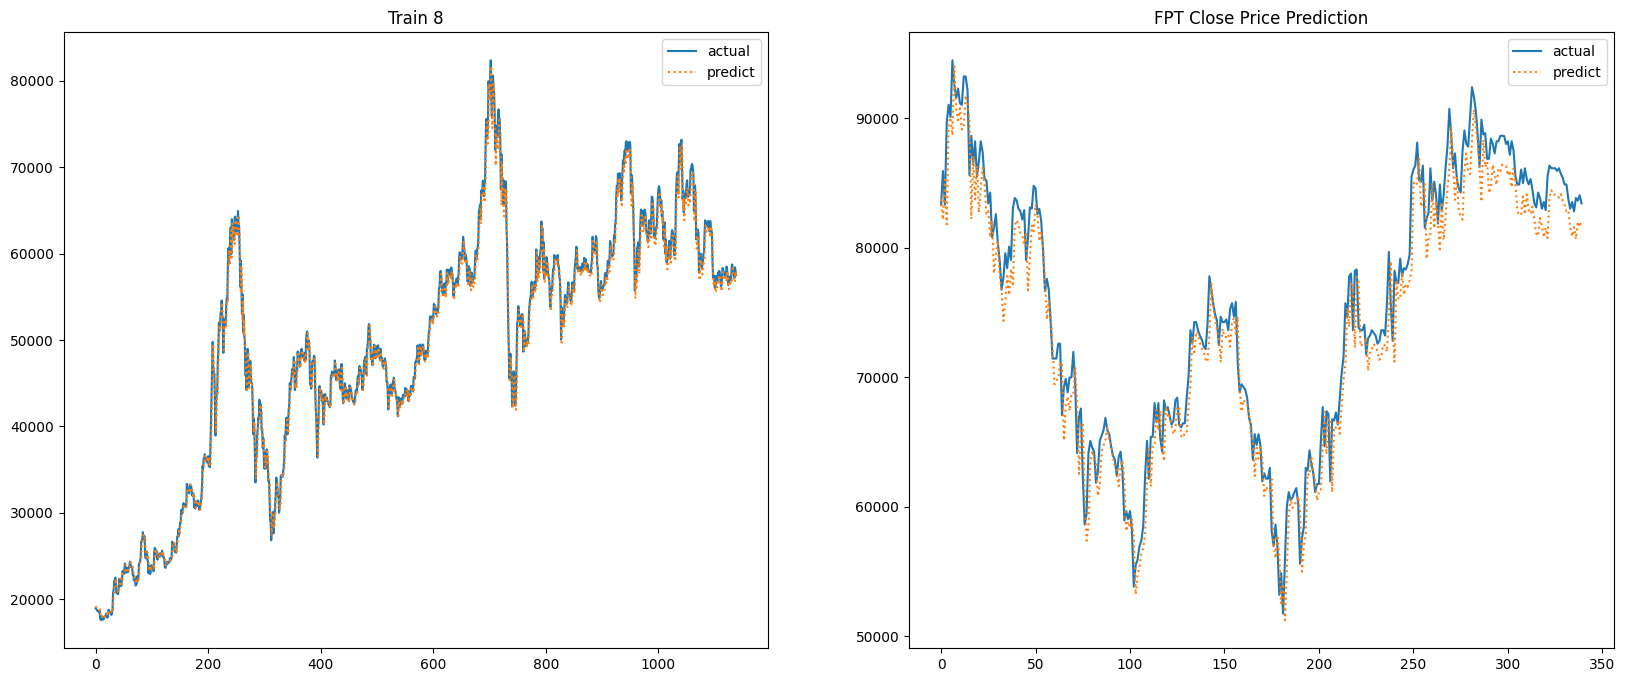

    rmse_train  mape_train    rmse_test  mape_test
0  1450.163741    0.021386  2504.108142   0.026702


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 8")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 2")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_FPT_82.png")
plt.title('FPT Close Price Prediction')
plt.show()

print(metrics_df)



---


**BIDV 7.5:2.5**



In [ ]:
# working on
token_id = 1 #BIDV

df = getRawData(token_id)
print(df.head(3))

            Price
Date             
1/3/2017  16158.2
1/4/2017  16302.3
1/5/2017  16248.3


In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.75)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/FPT/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/FPT/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
36/36 [==============================] - 8s 74ms/step - loss: 0.0360
Epoch 2/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0028
Epoch 3/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0017
Epoch 4/100
36/36 [==============================] - 4s 115ms/step - loss: 0.0016
Epoch 5/100
36/36 [==============================] - 3s 86ms/step - loss: 0.0015
Epoch 6/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0015
Epoch 7/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0014
Epoch 8/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0013
Epoch 9/100
36/36 [==============================] - 4s 123ms/step - loss: 0.0012
Epoch 10/100
36/36 [==============================] - 3s 79ms/step - loss: 0.0012
Epoch 11/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0012
Epoch 12/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 13/100
36/36 [===

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_6[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


11/11 [==============================] - 0s 29ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,1391.160265,0.020674,2036.513688,0.020756


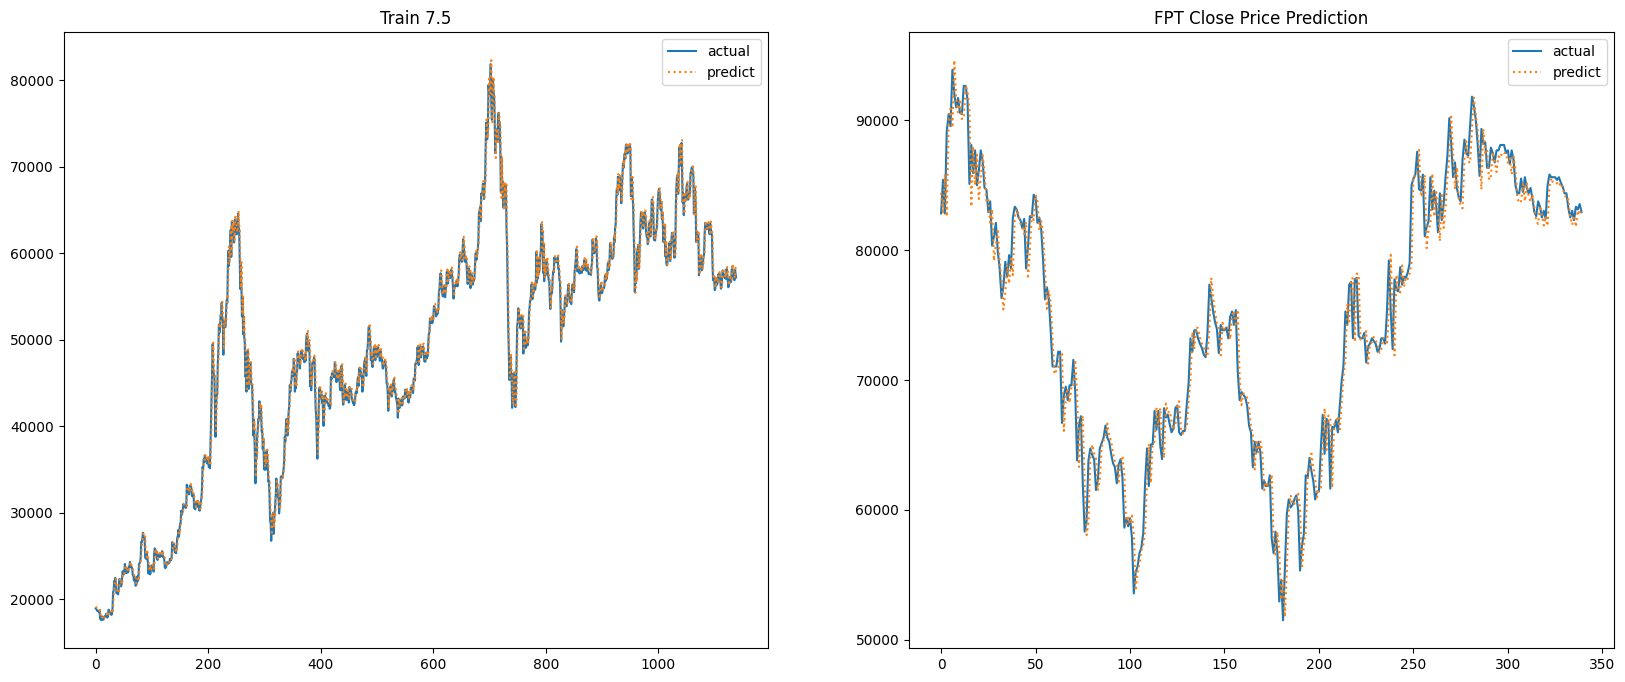

    rmse_train  mape_train    rmse_test  mape_test
0  1391.160265    0.020674  2036.513688   0.020756


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 7.5")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 2.5")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_FPT_7.5_2.5.png")
plt.title('FPT Close Price Prediction')
plt.show()

print(metrics_df)

# VCG





---


**VCG 7:3**

In [ ]:
# working on
token_id = 2 #BIDV

df = getRawData(token_id)
print(df.head(3))

           Price
Date            
1/3/2017  8912.8
1/4/2017  9175.0
1/5/2017  9371.6


In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.7)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/VCG/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/VCG/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
36/36 [==============================] - 9s 95ms/step - loss: 0.0383
Epoch 2/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0024
Epoch 3/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0015
Epoch 4/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0014
Epoch 5/100
36/36 [==============================] - 4s 117ms/step - loss: 0.0014
Epoch 6/100
36/36 [==============================] - 3s 85ms/step - loss: 0.0013
Epoch 7/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0013
Epoch 8/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0012
Epoch 9/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 10/100
36/36 [==============================] - 5s 128ms/step - loss: 0.0011
Epoch 11/100
36/36 [==============================] - 3s 76ms/step - loss: 0.0012
Epoch 12/100
36/36 [==============================] - 3s 74ms/step - loss: 0.0011
Epoch 13/100
36/36 [===

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_7[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


11/11 [==============================] - 0s 26ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,674.875401,0.019584,1062.530487,0.022383


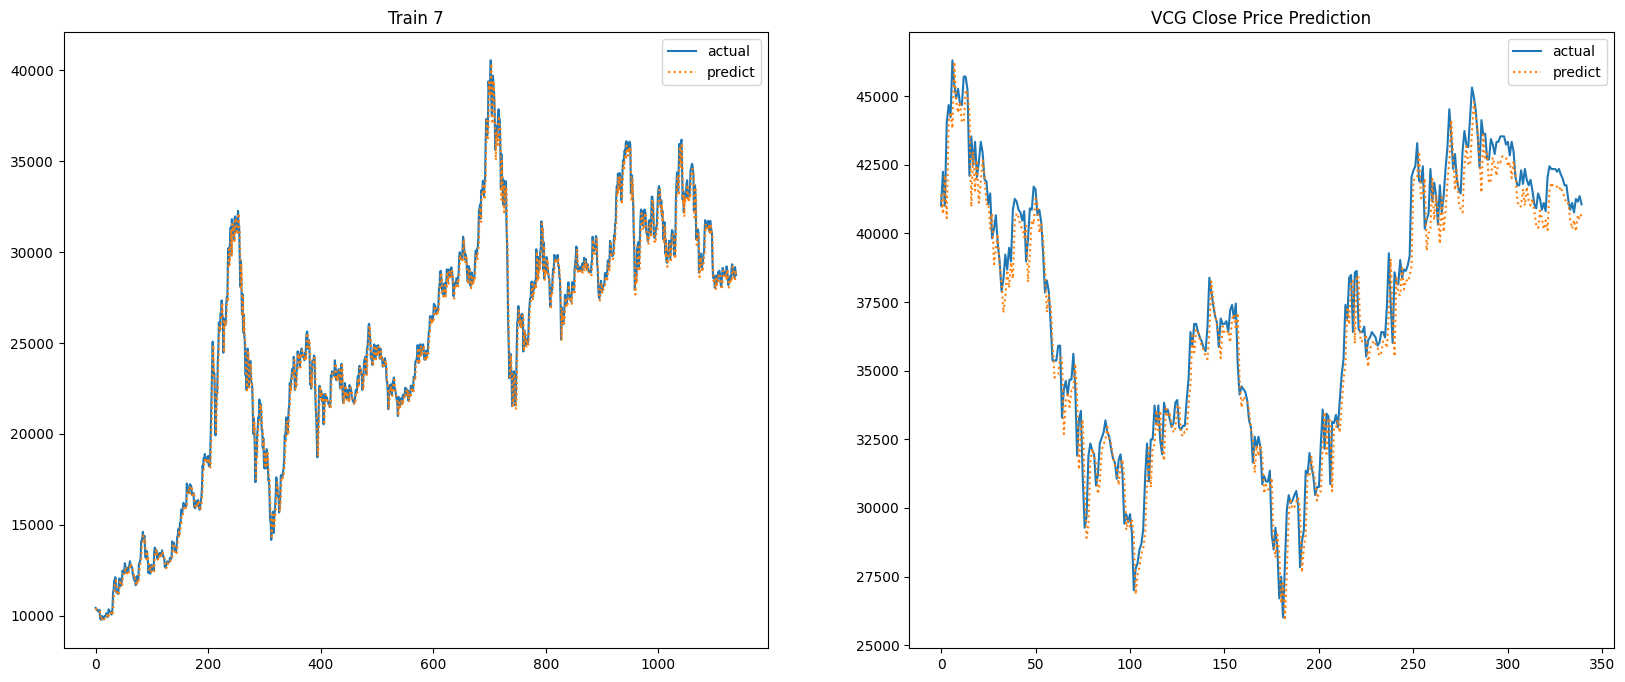

   rmse_train  mape_train    rmse_test  mape_test
0  674.875401    0.019584  1062.530487   0.022383


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 7")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 3")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_VCG_73.png")
plt.title('VCG Close Price Prediction')
plt.show()

print(metrics_df)



---


**BIDV 8:2**

In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.8)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/VCG/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/VCG/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
36/36 [==============================] - 8s 95ms/step - loss: 0.0344
Epoch 2/100
36/36 [==============================] - 4s 109ms/step - loss: 0.0023
Epoch 3/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0016
Epoch 4/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0015
Epoch 5/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0014
Epoch 6/100
36/36 [==============================] - 4s 100ms/step - loss: 0.0013
Epoch 7/100
36/36 [==============================] - 4s 99ms/step - loss: 0.0013
Epoch 8/100
36/36 [==============================] - 3s 71ms/step - loss: 0.0012
Epoch 9/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0011
Epoch 10/100
36/36 [==============================] - 3s 71ms/step - loss: 0.0012
Epoch 11/100
36/36 [==============================] - 4s 105ms/step - loss: 0.0011
Epoch 12/100
36/36 [==============================] - 3s 94ms/step - loss: 0.0011
Epoch 13/100
36/36 [==

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_8[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


11/11 [==============================] - 0s 29ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,848.214241,0.021517,1222.742375,0.021167


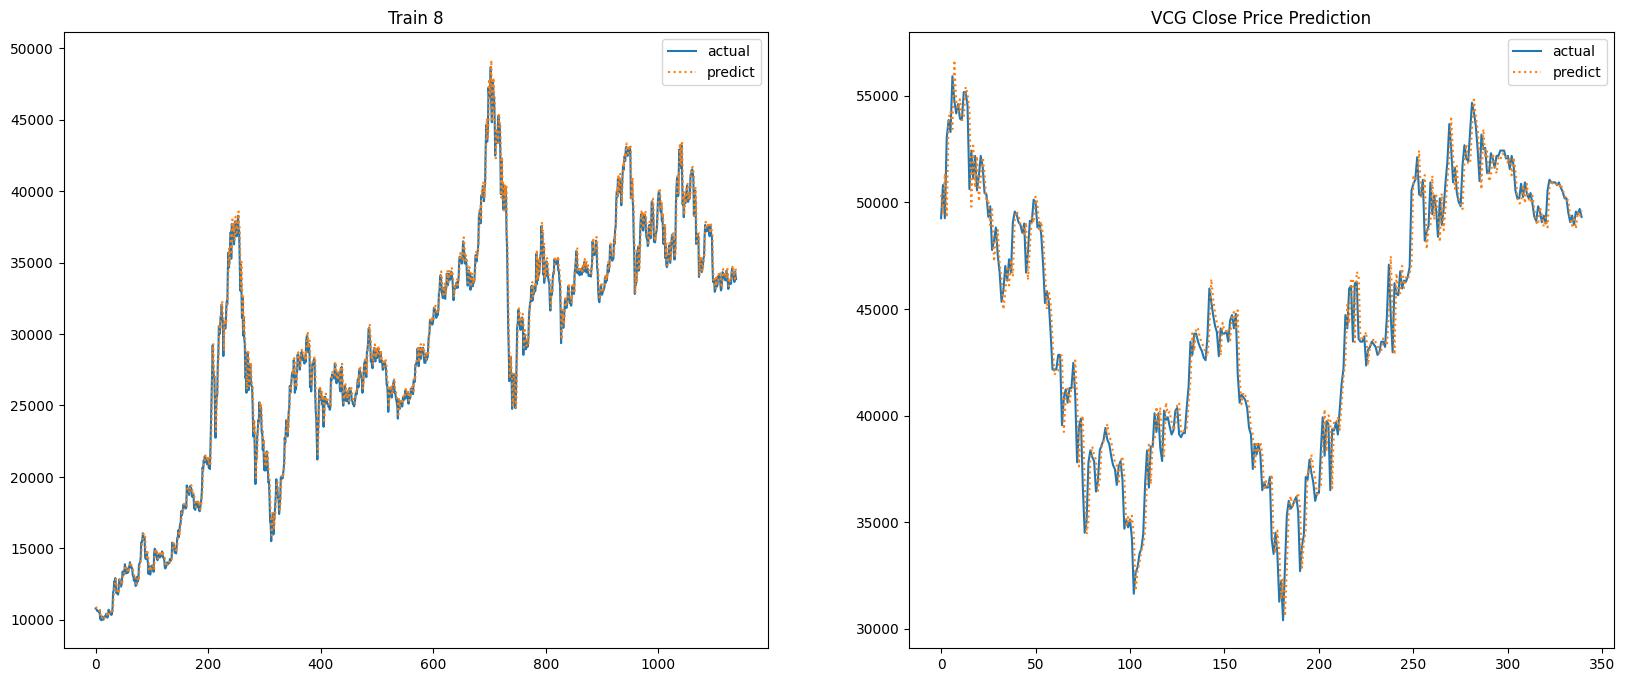

   rmse_train  mape_train    rmse_test  mape_test
0  848.214241    0.021517  1222.742375   0.021167


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 8")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 2")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_VCG_82.png")
plt.title('VCG Close Price Prediction')
plt.show()

print(metrics_df)



---


**BIDV 7.5:2.5**



In [ ]:
n_observations = df.shape[0]

train_size = int(n_observations*0.75)
test_size = n_observations - train_size

train = df[:train_size]
test = df[train_size: train_size + test_size]

In [ ]:
# MinMaxScaler
train_scaled, scaler = MinMaxNormalization(train, 1)
test_scaled, scaler = MinMaxNormalization(test, 2)

True
/content/drive/My Drive/BDA_report/processing/VCG/Price_train_scaler.xlsx
/content/drive/My Drive/BDA_report/processing/VCG/Price_test_scaler.xlsx


In [ ]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [ ]:
df_train = getData(subset="train")
df_test = getData(subset="test")

Xtrain, Ytrain = getSupervisedData(df_train, T, TF)
Xtest, Ytest = getSupervisedData(df_test, T, TF)

Xtrain = np.expand_dims(Xtrain, axis=2)
Xtest = np.expand_dims(Xtest, axis=2)

In [ ]:
#@title Train Model
model = Seq2SeqModel(T, NFeature)

history = model.fit(
        [Xtrain, np.zeros((Xtrain.shape[0], 1, 1))],
        Ytrain.reshape(-1, 1, 1),
        epochs = 100,
        batch_size= 32,
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/100
36/36 [==============================] - 7s 74ms/step - loss: 0.0265
Epoch 2/100
36/36 [==============================] - 3s 71ms/step - loss: 0.0025
Epoch 3/100
36/36 [==============================] - 3s 78ms/step - loss: 0.0016
Epoch 4/100
36/36 [==============================] - 4s 122ms/step - loss: 0.0016
Epoch 5/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0015
Epoch 6/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0013
Epoch 7/100
36/36 [==============================] - 3s 71ms/step - loss: 0.0013
Epoch 8/100
36/36 [==============================] - 3s 84ms/step - loss: 0.0012
Epoch 9/100
36/36 [==============================] - 4s 116ms/step - loss: 0.0012
Epoch 10/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0011
Epoch 11/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0011
Epoch 12/100
36/36 [==============================] - 3s 72ms/step - loss: 9.9603e-04
Epoch 13/100
36/36 

In [ ]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_" + targets[0])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_layer (LSTM)           [(None, 128),        66560       ['input_9[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [ ]:
metrics_df = {
    "rmse_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mape_test": []
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict([Xtrain, np.zeros((Xtrain.shape[0],1,1))])
y_pred_test = model.predict([Xtest, np.zeros((Xtest.shape[0],1,1))])

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}.xlsx")
metrics_df


11/11 [==============================] - 0s 28ms/step


,rmse_train,mape_train,rmse_test,mape_test
0,684.006015,0.021298,968.379268,0.019824


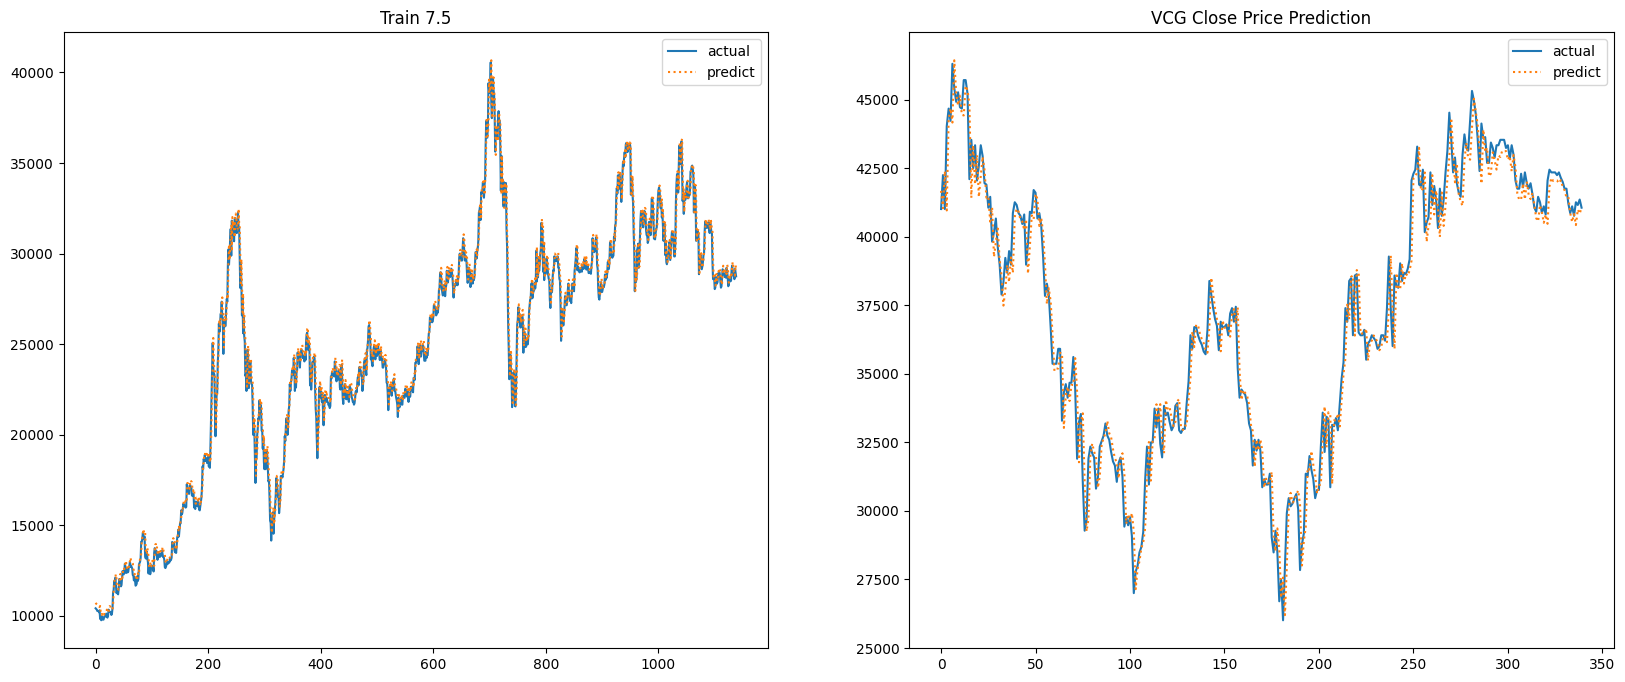

   rmse_train  mape_train   rmse_test  mape_test
0  684.006015    0.021298  968.379268   0.019824


In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# For Sine Function
axes[0].plot(y_true_train.squeeze(), label="actual")
axes[0].plot(pred_train.squeeze(), label="predict", linestyle="dotted")
axes[0].legend()
axes[0].set_title("Train 7.5")

# For Cosine Function
axes[1].plot(y_true_test.squeeze(), label="actual")
axes[1].plot(pred_test.squeeze(), label="predict", linestyle="dotted")
axes[1].legend()
axes[1].set_title("Test 2.5")


save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_VCG_7.5_2.5.png")
plt.title('VCG Close Price Prediction')
plt.show()

print(metrics_df)